In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Eye diseases

Diabetes is a condition that carries an increased risk of developing eye complications. Diabetic eye disease includes complications such as diabetic retinopathy, cataracts and glaucoma.

Diabetes is the leading cause of blindness in working-age adults. People with type 1 and type 2 diabetes are at risk. It’s possible to be unaware that you have severe diabetic eye disease and suddenly go blind. Fortunately, most cases of blindness can be prevented with regular eye examinations and proper care.

- The dataset consists of Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class have approximately 1000 images. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc.

- Diabetic retinopathy: The persistently high blood sugar levels that occur with diabetes can damage the retina’s small blood vessels (capillaries), which deliver oxygen and nutrients. Diabetic retinopathy affects up to a third of people with diabetes over the age of 502.

- Cataracts: A cataract is a clouding of the lens in the eye. Left untreated, cataracts can eventually lead to blindness. People with diabetes are more likely to develop cataracts at an earlier age and suffer visual impairment faster than those without the condition.1,3

- Glaucoma: This is a group of conditions that can damage the optic nerve. The optic nerve transmits signals from the retina to the brain for processing. Glaucoma is often (but not always) a result of increased pressure inside the eye. The risk of glaucoma in people with diabetes is significantly higher than that of the general population.1,4 The two main types are open-angle glaucoma (also called ‘the sneak thief of sight’) and angle-closure glaucoma (this comes on suddenly and is a medical emergency).

## Import Libraries

In [15]:
# import system libs
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Class for Loading and Splitting Datasets

In [16]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir

    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [17]:
dataDir='/content/drive/My Drive/Data-ML/after_cleaning'

In [18]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

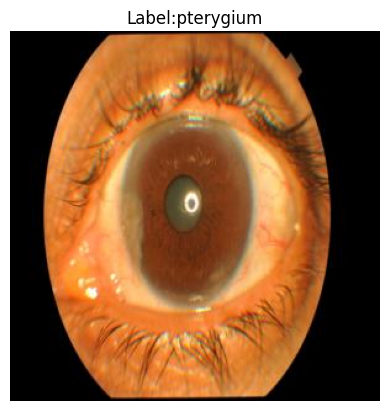

In [19]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']

    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

## Function for Data Augmentation

In [20]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'


    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])

    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of augmented training images:", train_generator.image_shape)

    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of validation images:", valid_generator.image_shape)

    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )

    print("Shape of test images:", test_generator.image_shape)

    return train_generator, valid_generator, test_generator

In [21]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 514 validated image filenames belonging to 3 classes.
Shape of augmented training images: (256, 256, 3)
Found 64 validated image filenames belonging to 3 classes.
Shape of validation images: (256, 256, 3)
Found 65 validated image filenames belonging to 3 classes.
Shape of test images: (256, 256, 3)


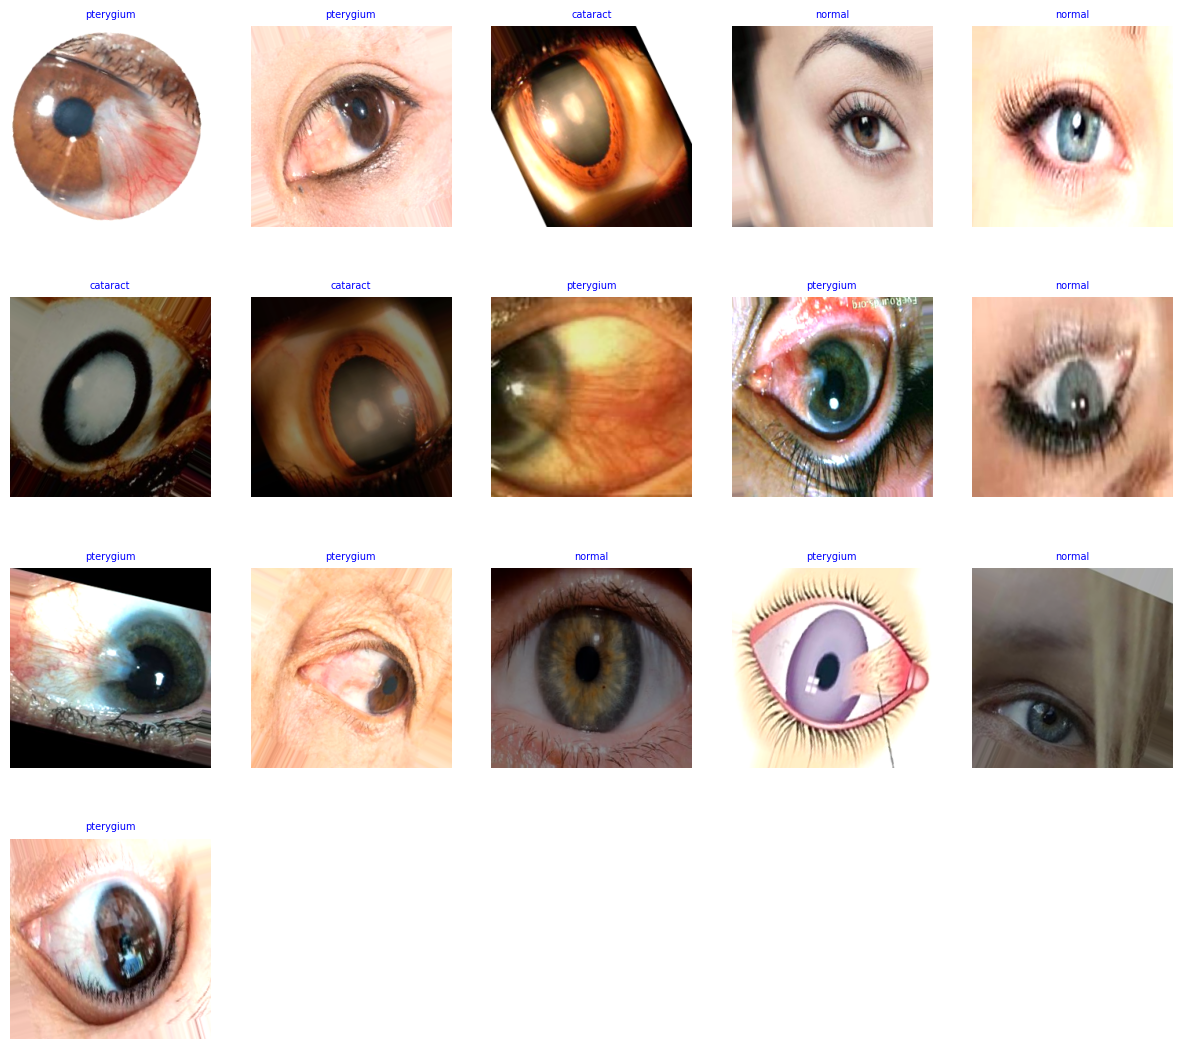

In [22]:
def show_images(gen):

    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)
    sample = min(length, 20)
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(train_augmented)

## Download and compile the model

In [23]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

predictions = Dense(classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Fit the model

In [24]:
history = model.fit(
    train_augmented,
    epochs=10,
    validation_data=valid_augmented,
    )

Epoch 1/10
33/33 [==============================] - 161s 4s/step - loss: 6.1421 - accuracy: 0.7471 - val_loss: 4.0839 - val_accuracy: 0.8125
Epoch 2/10
33/33 [==============================] - 142s 4s/step - loss: 2.9454 - accuracy: 0.8502 - val_loss: 2.4130 - val_accuracy: 0.7344
Epoch 3/10
33/33 [==============================] - 140s 4s/step - loss: 1.7748 - accuracy: 0.8638 - val_loss: 1.6356 - val_accuracy: 0.7656
Epoch 4/10
33/33 [==============================] - 132s 4s/step - loss: 1.2644 - accuracy: 0.8599 - val_loss: 1.2929 - val_accuracy: 0.8281
Epoch 5/10
33/33 [==============================] - 140s 4s/step - loss: 0.9783 - accuracy: 0.8891 - val_loss: 1.0315 - val_accuracy: 0.7969
Epoch 6/10
33/33 [==============================] - 142s 4s/step - loss: 0.8054 - accuracy: 0.8911 - val_loss: 1.1035 - val_accuracy: 0.7500
Epoch 7/10
33/33 [==============================] - 141s 4s/step - loss: 0.8080 - accuracy: 0.8444 - val_loss: 0.9905 - val_accuracy: 0.7812
Epoch 8/10
33

## Plot the Accuracy and Loss

Training Accuracy: 0.8910505771636963
Validation Accuracy: 0.859375


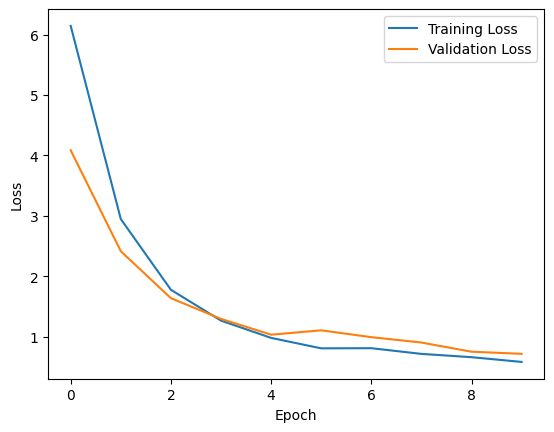

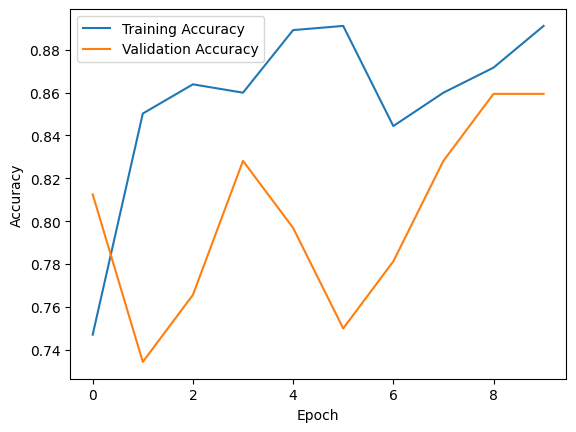

In [25]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Display the Actual and Predicted images

1/1 [==============================] - 8s 8s/step


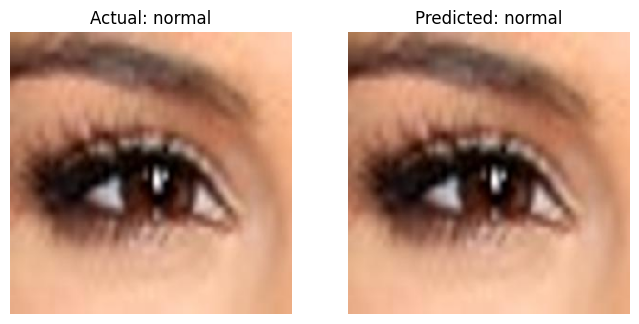

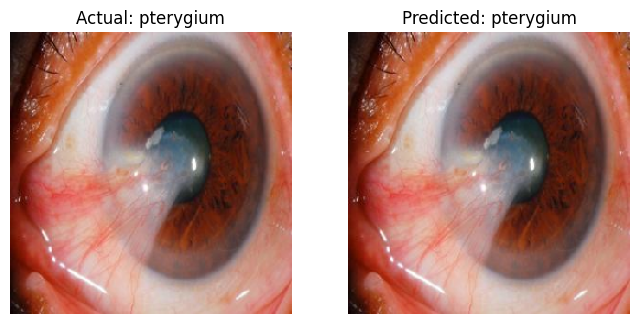

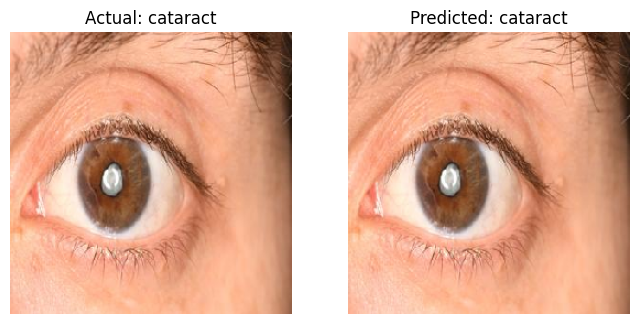

In [26]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):

    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)